# Exploring sea ice heights with ICESat-2 (ATL07)

Information obtained primarily from the ATL07/10 Algorithm Theoretical Basis Document (ATBD, Kwok et al., 2019) and the NSIDC product description page: https://nsidc.org/data/atl07.   

* Notebook author: Ellen Buckley, heavily based on 2019 Hackweek notebook by Alek Petty, and  relying extensively on above product manuals.    
* Description: Notebook describing the ICESat-2 ATL07 product.   
* Input requirements: Demo ATL07 data file   
* Date: June 2020
* More info: See the ATL07/ATL10 Algorithm Theoretical Basis Document (ATBD): https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL07_ATL10_ATBD_r001.pdf    and the known issues document: https://nsidc.org/sites/nsidc.org/files/technical-references/ATL0710-KnownIssues.pdf


## Notebook objectives
* General understanding of the data included in a typical ATL07 file.
* Reading in, plotting and basic analysis of ATL07 data.
* How is ATL07 data used to generate ATL10 sea ice freeboards and what to look out for when using either product.


In [1]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py
#import s3fs
from astropy.time import Time
#from icepyx import icesat2data as ipd

## Select and Import Data

#### Granule Selection

So that we can compare the ATL07 data with the ATL03 data in this notebook, we will pull the same RGT for ATL07.

Naming convention for ATL07 files: Instead of 14 regions, there are only 2: Northern Hemisphere (01), and Southern Hemisphere (02). For Northern Hemisphere products look for files that start with 'ATL07-01'

In this example we will be using: 'ATL07-01_20190206121103_06120201_002_01.h5'

#### Import Data

You can either grab this file from Amazon S3 (at the hackweek) or download from NSIDC if you are running this on your local machine

In [57]:
fname='ATL07-01_20190206121103_06120201_002_01.h5'

f = h5py.File(fname, 'r')
#check to see if it is forward (1)  or backward (0) orientation to know which beam is strong/weak
print(f['orbit_info/sc_orient'][0])

0


We know we are in backward orientation because we are using same rgt from same day as  the ATL03 example but it just as easy to check. Here are the ATL07 parameters we are interested in using in this notebook:

In Group: gtx/sea_ice_segments/
* latitude
* longitude
* delta_time
* seg_dist_x

In Group: gtx/sea_ice_segments/heights/
* height_segment_height
* height_segment_confidence
* height_segment_type
* height_segment_ssh_flag
* height_segment_w_gaussian

In Group: gtx/sea_ice_segments/stats/
* photon_rate
* cloud_flag_asr

In Group: gtx/sea_ice_segments/geophysical/
* height_segment_mss

In [60]:
beam='gt1l'
lats = f[beam+'/sea_ice_segments/latitude'][:]
lons = f[beam+'/sea_ice_segments/longitude'][:]
dt = f[beam+'/sea_ice_segments/delta_time'][:]
seg_x = f[beam+'/sea_ice_segments/seg_dist_x'][:]
heights = f[beam+'/sea_ice_segments/heights/height_segment_height'][:]
conf = f[beam+'/sea_ice_segments/heights/height_segment_confidence'][:]
stype = f[beam+'/sea_ice_segments/heights/height_segment_type'][:]
ssh_flag = f[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:]
gauss = f[beam+'/sea_ice_segments/heights/height_segment_w_gaussian'][:]
photon_rate = f[beam+'/sea_ice_segments/stats/photon_rate'][:]
cloud = f[beam+'/sea_ice_segments/stats/cloud_flag_asr'][:]
mss= f[beam+'/sea_ice_segments/geophysical/height_segment_mss'][:]

In [61]:
df07=pd.DataFrame({'lats':lats,'lons':lons,'heights':heights,'dt':dt,'conf':conf,'stype':stype,'ssh_flag':ssh_flag,'gauss':gauss,'photon_rate':photon_rate,'cloud':cloud, 'mss':mss})
df07.head()

,lats,lons,heights,dt,conf,stype,ssh_flag,gauss,photon_rate,cloud,mss
0,64.281472,-39.976563,3.402823e+38,3.469127e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,44.757393
1,82.322344,-52.260822,3.402823e+38,3.469156e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,1,18.460447
2,82.322344,-52.260822,3.402823e+38,3.469156e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,1,18.460447
3,82.322344,-52.260822,3.402823e+38,3.469156e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,1,18.460447
4,82.322344,-52.260822,3.402823e+38,3.469156e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,1,18.460447


## Map data


#### Cloud flag

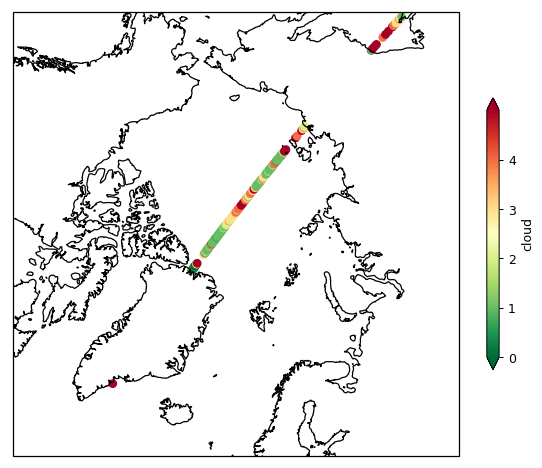

In [62]:
var= 'cloud' #choose which variable we want to plot

## we will want to set colorbar parameters based on the chosen variable
vmin=0
vmax=5
ticks=np.arange(vmin,vmax,1)


plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
plt.scatter(df07['lons'][::1000], df07['lats'][::1000],c=df07[var][::1000], cmap=plt.cm.get_cmap('RdYlGn').reversed(), vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both')

## Impact of Clouds on Data

Here we investigate a section of data that transitions from clear to cloudy and see how that impacts the parameters

#### How do clouds affect parameters?

In [63]:
# cut to region that has clear and cloudy data
#region=(df07.lats>83.3)&(df07.lats<83.7)&(df07.lons<0)
#df07_cut=df07[region]

In [64]:
# cut to region that has clear and cloudy data
region=(df07.lats>86)&(df07.lats<86.5)&(df07.lons<-50)
df07_cut=df07[region]

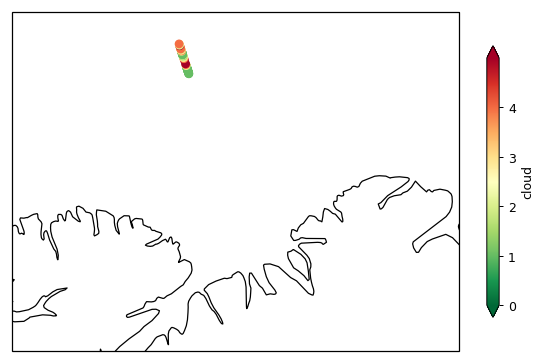

In [65]:
var= 'cloud' #choose which variable we want to plot

## we will want to set colorbar parameters based on the chosen variable
vmin=0
vmax=5
ticks=np.arange(vmin,vmax,1)


plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-55)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-80, -30, 80, 87], ccrs.PlateCarree())
plt.scatter(df07_cut['lons'][::100], df07_cut['lats'][::100],c=df07_cut[var][::100], cmap=plt.cm.get_cmap('RdYlGn').reversed(), vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both')

Text(0,0.5,'photon rate')

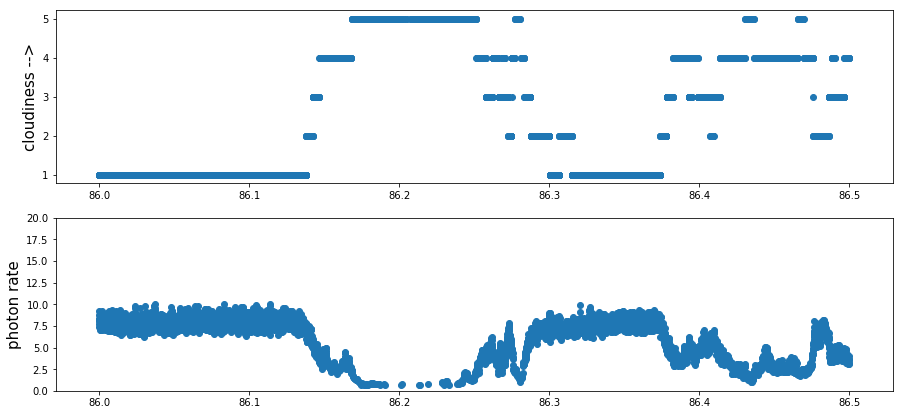

In [12]:
fig,ax=plt.subplots(2,1,figsize=(15,7))
ax[0].scatter(df07_cut.lats,df07_cut.cloud)
ax[0].set_ylabel('cloudiness -->',fontsize=15)
ax[1].scatter(df07_cut.lats,df07_cut.photon_rate)
ax[1].set_ylim(0,20)
ax[1].set_ylabel('photon rate',fontsize=15)

#### Lets look at how clouds affect the ATL03 data

In [20]:
fname='ATL03_20190206123200_06120204_002_01.h5'
f = h5py.File(fname, 'r')
beam='gt1l'
heights=f[beam+'/heights/h_ph'][:]
lats=f[beam+'/heights/lat_ph'][:]
lons=f[beam+'/heights/lon_ph'][:]
dt=f[beam+'/heights/delta_time'][:]# time is in seconds 
epoch=f['/ancillary_data/atlas_sdp_gps_epoch'][0]
conf=f[beam+'/heights/signal_conf_ph'][:,2] #choose column 2 for confidence of sea ice photons

#import corrections to compare with ATL07
geoid= f[beam+'/geophys_corr/geoid'][:]#geoid
tide= f[beam+'/geophys_corr/tide_ocean'][:]#ocean tide
dac= f[beam+'/geophys_corr/dac'][:]#dynamic atmosphere
corr_dt=f[beam+'/geophys_corr/delta_time'][:]#dynamic atmosphere

df03=pd.DataFrame({'lats':lats,'lons':lons,'heights':heights,'dt':dt,'conf':conf})
corr=pd.DataFrame({'dt':corr_dt,'geoid':geoid,'dac':dac,'tide':tide})
df03.head()


,lats,lons,heights,dt,conf
0,79.990105,-48.420387,1988.997803,3.469152e+07,-1
1,79.990104,-48.420387,1989.362915,3.469152e+07,-1
2,79.990104,-48.420387,1989.231079,3.469152e+07,-1
3,79.990104,-48.420387,1989.333374,3.469152e+07,-1
4,79.990105,-48.420389,1985.447388,3.469152e+07,-1


In [21]:
# cut df03 to region of interest
region=(df03.lats>86)&(df03.lats<86.5)&(df03.lons<-50)
df03_cut=df03[region]

Text(0.5,0,'latitude')

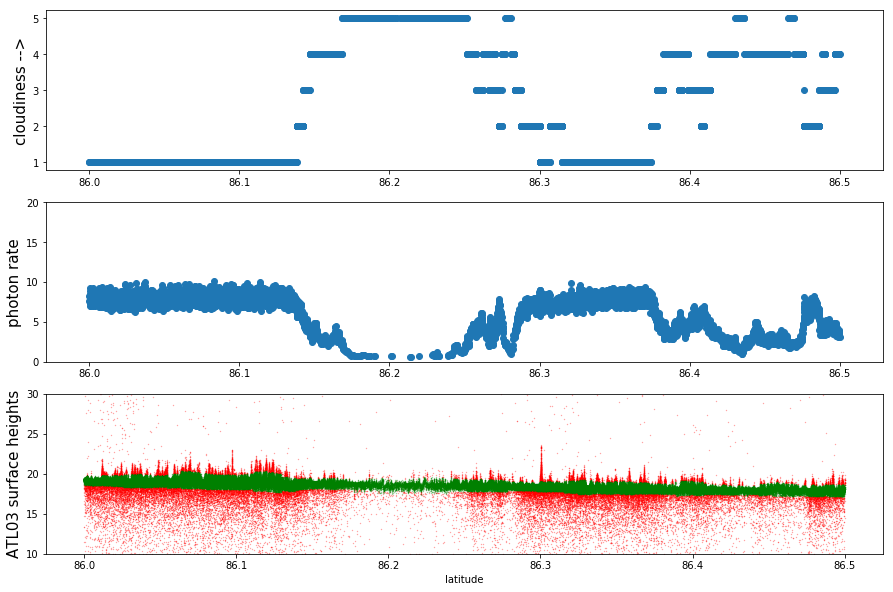

In [22]:
fig,ax=plt.subplots(3,1,figsize=(15,10))
ax[0].scatter(df07_cut.lats,df07_cut.cloud)
ax[0].set_ylabel('cloudiness -->',fontsize=15)
ax[1].scatter(df07_cut.lats,df07_cut.photon_rate)
ax[1].set_ylim(0,20)
ax[1].set_ylabel('photon rate',fontsize=15)
ax[2].scatter(df03_cut.lats[df03_cut.conf<3],df03_cut.heights[df03_cut.conf<3],c='r',s=.1,alpha=.5)
ax[2].scatter(df03_cut.lats[df03_cut.conf>2],df03_cut.heights[df03_cut.conf>2],c='g',s=.1,alpha=.5)
ax[2].set_ylim(10,30)
ax[2].set_ylabel('ATL03 surface heights',fontsize=15)
ax[2].set_xlabel('latitude')

In [14]:
# zoom in on transition
# cut to region that has clear and cloudy data
region=(df07.lats>86.1)&(df07.lats<86.2)&(df07.lons<-50)
df07_cut=df07[region]
# cut df03 to region of interest
region=(df03.lats>86.1)&(df03.lats<86.2)&(df03.lons<-50)
df03_cut=df03[region]

Text(0.5,0,'latitude')

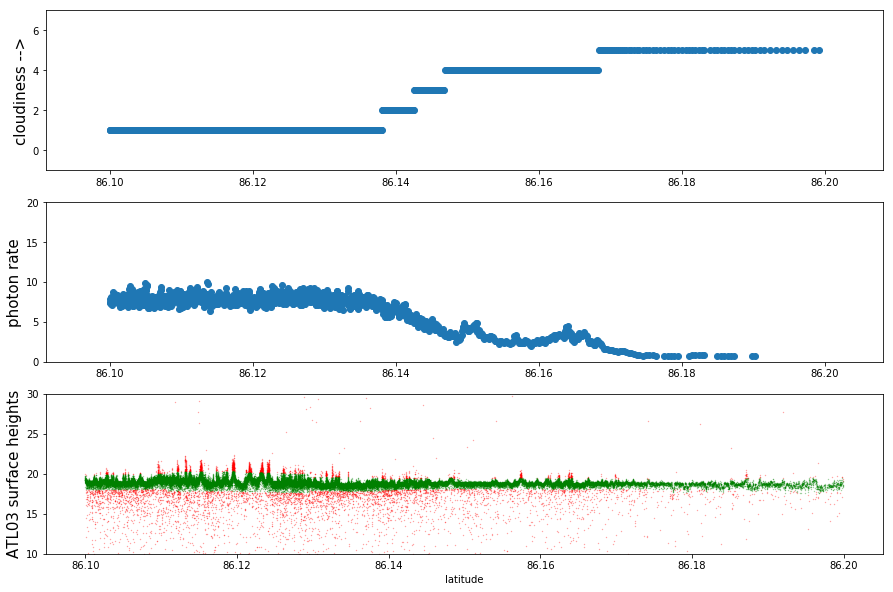

In [15]:
fig,ax=plt.subplots(3,1,figsize=(15,10))
ax[0].scatter(df07_cut.lats,df07_cut.cloud)
ax[0].set_ylabel('cloudiness -->',fontsize=15)
ax[0].set_ylim(-1,7)
ax[1].scatter(df07_cut.lats,df07_cut.photon_rate)
ax[1].set_ylim(0,20)
ax[1].set_ylabel('photon rate',fontsize=15)
ax[2].scatter(df03_cut.lats[df03_cut.conf<3],df03_cut.heights[df03_cut.conf<3],c='r',s=.1,alpha=.5)
ax[2].scatter(df03_cut.lats[df03_cut.conf>2],df03_cut.heights[df03_cut.conf>2],c='g',s=.1,alpha=.5)
ax[2].set_ylim(10,30)
ax[2].set_ylabel('ATL03 surface heights',fontsize=15)
ax[2].set_xlabel('latitude')

## Surface type classification

Not we want to look at the surface type classifications in ATL07 and think about how these are used to generate ATL10

Surface type paramter: Value that indicates segment surface type as sea ice or different types of sea surface. 

 0 cloud_covered 
 
 1 other 
 
 2 specular_lead_low_w_bkg 
 
 3 specular_lead_low 
 
 4 specular_lead_high_w_bkg 
 
 5 specular_lead_high 
 
 6 dark_lead_smooth_w_bkg 
 
 7 dark_lead_smooth 
 
 8 dark_lead_rough_w_bkg 
 
 9 dark_lead_rough

In [98]:
# Let's just look at the cloud free section from above
# cut to region that has clear and cloudy data
latmin,latmax=[81.748,81.753]
region=(df07.lats>latmin)&(df07.lats<latmax)&(df07.lons>0)
df07_cut=df07[region]
# cut df03 to region of interest
region=(df03.lats>latmin)&(df03.lats<latmax)&(df03.lons>0)
df03_cut=df03[region]

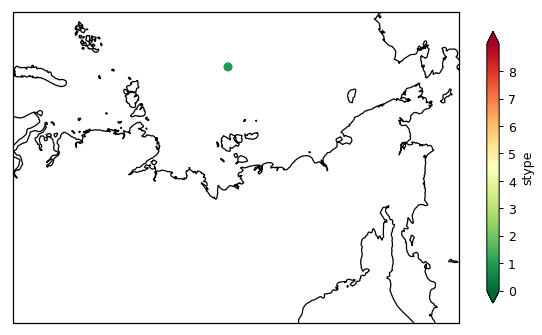

In [99]:
var= 'stype' #choose which variable we want to plot

## we will want to set colorbar parameters based on the chosen variable
vmin=0
vmax=9
ticks=np.arange(vmin,vmax,1)


plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=120)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([90, 180, 60, 87], ccrs.PlateCarree())
plt.scatter(df07_cut['lons'][::100], df07_cut['lats'][::100],c=df07_cut[var][::100], cmap=plt.cm.get_cmap('RdYlGn').reversed(), vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both')

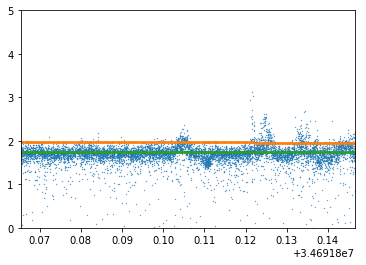

In [122]:
## temp
import scipy


plt.xlim(min(df03_cut.dt),max(df03_cut.dt))
plt.ylim(0,5)
geo_corr=scipy.interpolate.interp1d(corr.dt.values,corr.dac.values+corr.geoid.values+corr.tide.values)
mss_corr=scipy.interpolate.interp1d(df07.dt.values,df07.mss.values)
a=geo_corr(df03_cut.dt.values)
df03_cut['correction']=np.array(a)
df03_cut['mss']=mss_corr(df03_cut.dt.values)

plt.scatter(df03_cut.dt,df03_cut.heights,s=.1)
plt.scatter(df03_cut.dt,df03_cut.correction,s=.1)
plt.scatter(df03_cut.dt,df03_cut.mss,s=.1)


Text(0.5,0,'latitude')

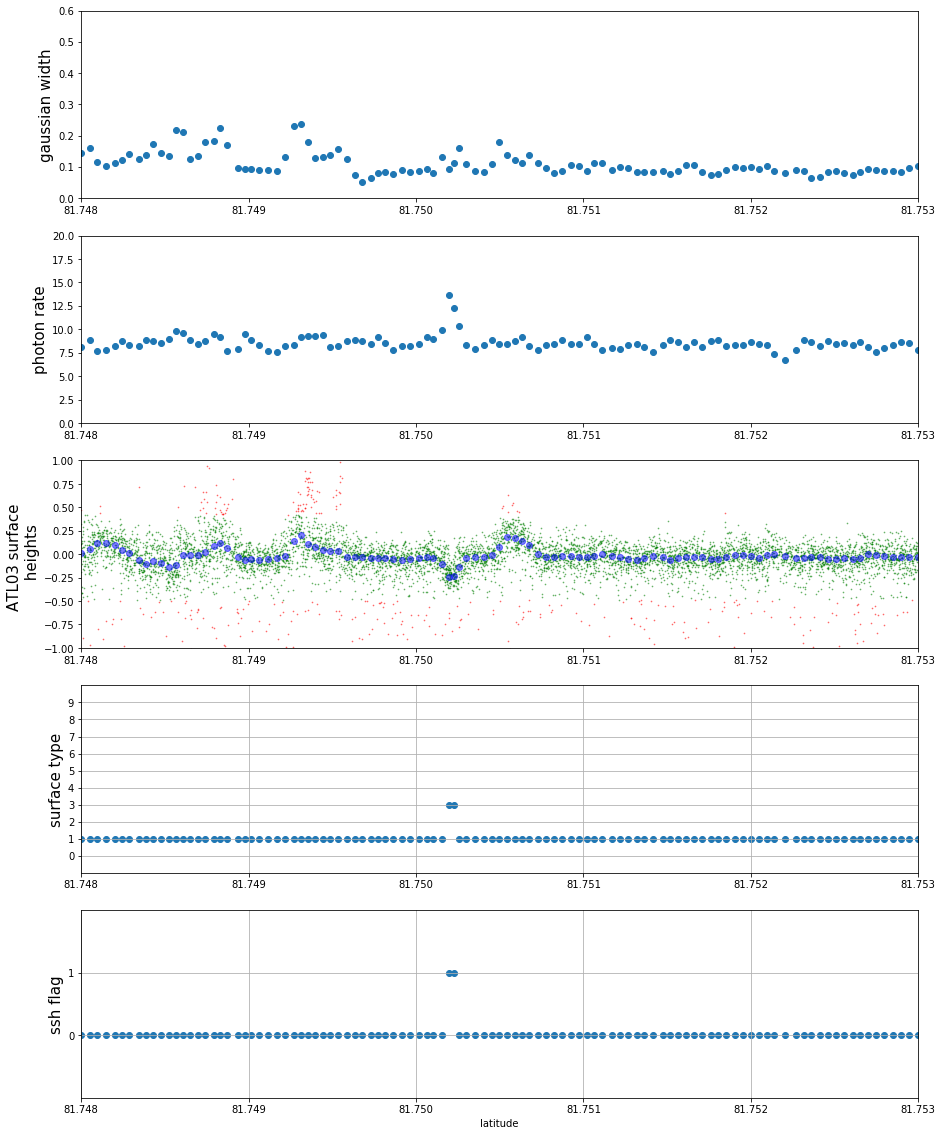

In [123]:
fig,ax=plt.subplots(5,1,figsize=(15,20))



ax[0].scatter(df07_cut.lats,df07_cut.gauss)
ax[0].set_ylabel('gaussian width',fontsize=15)
ax[0].set_ylim(0,.6)
ax[0].set_xlim(latmin,latmax)
ax[1].scatter(df07_cut.lats,df07_cut.photon_rate)
ax[1].set_ylim(0,20)
ax[1].set_ylabel('photon rate',fontsize=15)
ax[1].set_xlim(latmin,latmax)
ax[2].scatter(df03_cut.lats[df03_cut.conf<3],df03_cut.heights[df03_cut.conf<3]-df03_cut.mss[df03_cut.conf<3],c='r',s=.5,alpha=.5)
ax[2].scatter(df03_cut.lats[df03_cut.conf>2],df03_cut.heights[df03_cut.conf>2]-df03_cut.mss[df03_cut.conf>2],c='g',s=.5,alpha=.5)
ax[2].scatter(df07_cut.lats,df07_cut.heights,c='b',alpha=.5)
ax[2].set_ylim(-1,1)
ax[2].set_xlim(latmin,latmax)
ax[2].set_ylabel('ATL03 surface \n heights',fontsize=15)

ax[3].scatter(df07_cut.lats,df07_cut.stype)
ax[3].set_ylim(-1,10)
ax[3].set_ylabel('surface type',fontsize=15)
ax[3].set_xlim(latmin,latmax)
ax[3].grid()
ax[3].set_yticks(np.arange(0,10,1))
ax[4].scatter(df07_cut.lats,df07_cut.ssh_flag)
ax[4].grid()
ax[4].set_ylim(-1,2)
ax[4].set_yticks(np.arange(0,2,1))
ax[4].set_ylabel('ssh flag',fontsize=15)
ax[4].set_xlim(latmin,latmax)
ax[4].set_xlabel('latitude')

## Moving on to ATL10

Here we are looking at the segment type classifications and talking about how ATL07 is used to generate ATL10

#### Beam selection   
There are 6 beams to choose from in the ICESat-2 products (3 pairs of a strong and weak beam). The energy ratio between the weak and strong beams are  approximately 1:4 and are separated by 90 m in the across-track direction. The beam pairs are separated by ~3.3 km in the across-track direction, and the strong and weak beams are separated by ~2.5 km in the along-track direction.

In [3]:
beamNum=1

In [4]:
# If file stored locally...
#file_path = '../Data/'
#ATL07_filename = 'ATL07-01_20181115003141_07240101_001_01.h5'
#localPath = file_path + ATL07_filename

In [11]:
# If running on Pangeo instance and grabbing data from Amazon S3
# Comment out the last command if you've already got the data in the Data dir
bucket = 'pangeo-data-upload-oregon'
fs = s3fs.S3FileSystem()
dataDir = 'pangeo-data-upload-oregon/icesat2/'
s3List = fs.ls(dataDir)
#print(s3List)
ATL07file='ATL07-01_20181115003141_07240101_001_01.h5'
s3File='pangeo-data-upload-oregon/icesat2/'+ATL07file
localFilePath='../Data/'+ATL07file
#fs.get(s3File, localFilePath)

In [8]:
def getATL07data(fileT, numpy=False, beamNum=1, maxElev=1e6):
    """ Pandas/numpy ATL07 reader
    Written by Alek Petty, June 2018 (alek.a.petty@nasa.gov)

    I've picked out the variables from ATL07 I think are of most interest to sea ice users, but by no means is this an exhastive list. 
    See the xarray or dictionary readers to load in the more complete ATL07 dataset
    or explore the hdf5 files themselves (I like using the app Panpoly for this) to see what else you might want
    
    Args:
        fileT (str): File path of the ATL07 dataset
        numpy (flag): Binary flag for outputting numpy arrays (True) or pandas dataframe (False)
        beamNum (int): ICESat-2 beam number (1 to 6)
        maxElev (float): maximum surface elevation to remove anomalies

    returns:
        either: select numpy arrays or a pandas dataframe
        
    Updates:
        V3 (June 2018) added observatory orientation flag, read in the beam number, not the string
        V2 (June 2018) used astropy to more simply generate a datetime instance form the gps time

    """
    
    # Open the file
    try:
        ATL07 = h5py.File(fileT, 'r')
    except:
        return 'Not a valid file'
    
    #flag_values: 0, 1, 2; flag_meanings : backward forward transition
    orientation_flag=ATL07['orbit_info']['sc_orient'][:]
    
    if (orientation_flag==0):
        print('Backward orientation')
        beamStrs=['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
                
    elif (orientation_flag==1):
        print('Forward orientation')
        beamStrs=['gt3r', 'gt3l', 'gt2r', 'gt2l', 'gt1r', 'gt1l']
        
    elif (orientation_flag==2):
        print('Transitioning, do not use for science!')
    
    beamStr=beamStrs[beamNum-1]
    print(beamStr)
    
    lons=ATL07[beamStr+'/sea_ice_segments/longitude'][:]
    lats=ATL07[beamStr+'/sea_ice_segments/latitude'][:]
    
    # Along track distance 
    # I removed the first point so it's distance relative to the start of the beam
    along_track_distance=ATL07[beamStr+'/sea_ice_segments/seg_dist_x'][:] - ATL07[beamStr+'/sea_ice_segments/seg_dist_x'][0]
    # Height segment ID (10 km segments)
    height_segment_id=ATL07[beamStr+'/sea_ice_segments/height_segment_id'][:] 
    # Number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    delta_time=ATL07[beamStr+'/sea_ice_segments/delta_time'][:] 
    # Add this value to delta time parameters to compute full gps time
    atlas_epoch=ATL07['/ancillary_data/atlas_sdp_gps_epoch'][:] 

    leapSecondsOffset=37
    gps_seconds = atlas_epoch[0] + delta_time - leapSecondsOffset
    # Use astropy to convert from gps time to datetime
    tgps = Time(gps_seconds, format='gps')
    tiso = Time(tgps, format='datetime')
    
    # Primary variables of interest
    
    # Beam segment height
    elev=ATL07[beamStr+'/sea_ice_segments/heights/height_segment_height'][:]
    # Flag for potential leads, 0=sea ice, 1 = sea surface
    ssh_flag=ATL07[beamStr+'/sea_ice_segments/heights/height_segment_ssh_flag'][:] 
    
    #Quality metrics for each segment include confidence level in the surface height estimate, 
    # which is based on the number of photons, the background noise rate, and the error measure provided by the surface-finding algorithm.
    # Height quality flag, 1 for good fit, 0 for bad
    quality=ATL07[beamStr+'/sea_ice_segments/heights/height_segment_quality'][:] 
    
    elev_rms = ATL07[beamStr+'/sea_ice_segments/heights/height_segment_rms'][:] #RMS difference between modeled and observed photon height distribution
    seg_length = ATL07[beamStr+'/sea_ice_segments/heights/height_segment_length_seg'][:] # Along track length of segment
    height_confidence = ATL07[beamStr+'/sea_ice_segments/heights/height_segment_confidence'][:] # Height segment confidence flag
    reflectance = ATL07[beamStr+'/sea_ice_segments/heights/height_segment_asr_calc'][:] # Apparent surface reflectance
    ssh_flag = ATL07[beamStr+'/sea_ice_segments/heights/height_segment_ssh_flag'][:] # Flag for potential leads, 0=sea ice, 1 = sea surface
    seg_type = ATL07[beamStr+'/sea_ice_segments/heights/height_segment_type'][:] # 0 = Cloud covered
    gauss_width = ATL07[beamStr+'/sea_ice_segments/heights/height_segment_w_gaussian'][:] # Width of Gaussian fit

    # Geophysical corrections
    # NOTE: All of these corrections except ocean tides, DAC, 
    # and geoid undulations were applied to the ATL03 photon heights.
    
    # AVISO dynamic Atmospheric Correction (DAC) including inverted barometer (IB) effect (±5cm)
    dac = ATL07[beamStr+'/sea_ice_segments/geophysical/height_segment_dac'][:] 
    # Solid Earth Tides (±40 cm, max)
    earth = ATL07[beamStr+'/sea_ice_segments/geophysical/height_segment_earth'][:]
    # Geoid (-105 to +90 m, max)
    geoid = ATL07[beamStr+'/sea_ice_segments/geophysical/height_segment_geoid'][:] 
    # Local displacement due to Ocean Loading (-6 to 0 cm)
    loadTide = ATL07[beamStr+'/sea_ice_segments/geophysical/height_segment_load'][:] 
    # Ocean Tides including diurnal and semi-diurnal (harmonic analysis), 
    # and longer period tides (dynamic and self-consistent equilibrium) (±5 m)
    oceanTide = ATL07[beamStr+'/sea_ice_segments/geophysical/height_segment_ocean'][:]
    # Deformation due to centrifugal effect from small variations in polar motion 
    # (Solid Earth Pole Tide) (±1.5 cm, the ocean pole tide ±2mm amplitude is considered negligible)
    poleTide = ATL07[beamStr+'/sea_ice_segments/geophysical/height_segment_pole'][:] 
    # Mean sea surface (±2 m)
    # Taken from ICESat and CryoSat-2, see Kwok and Morison [2015])
    mss = ATL07[beamStr+'/sea_ice_segments/geophysical/height_segment_mss'][:]
    
    # Photon rate of the given segment
    photon_rate = ATL07[beamStr+'/sea_ice_segments/stats/photon_rate'][:]
    
    # Estimated background rate from sun angle, reflectance, surface slope
    background_rate = ATL07[beamStr+'/sea_ice_segments/stats/backgr_calc'][:]
    
    
    
    ATL07.close()
    
    if numpy:
        # list the variables you want to output here..
        return along_track_dist, elev
    
    else:
        dF = pd.DataFrame({'elev':elev, 'lons':lons, 'lats':lats, 'ssh_flag':ssh_flag,
                          'quality_flag':quality,
                           'delta_time':delta_time,
                           'along_track_distance':along_track_distance,
                           'height_segment_id':height_segment_id, 
                           'photon_rate':photon_rate,'background_rate':background_rate,
                          'datetime':tiso, 'mss': mss, 'seg_length':seg_length})
        
         # Add the datetime string
        #dFtimepd=pd.to_datetime(dFtime)
        #dF['datetime'] = pd.Series(dFtimepd, index=dF.index)
        
        # Filter out high elevation values 
        dF = dF[(dF['elev']<maxElev)]
        # Reset row indexing
        dF=dF.reset_index(drop=True)
        return dF


#### Read in the data using the pandas reader above. Copied from the readers.py script.

Take a look at the top few rows (change the number in head to increase this..)


In [10]:
dF07=getATL07data(localFilePath, beamNum=beamNum)
dF07.head(5)

# Or get data using xarray
#dF07X= rd.getATL07xarray(localFilePath, beamStr)
#dF07X

# ...Or data using numpy
#along_track_dist, elev=getATL07data(ATL07_file_path, numpy=1, beam=beamStr)

Forward orientation
gt3r


,elev,lons,lats,ssh_flag,quality_flag,delta_time,along_track_distance,height_segment_id,photon_rate,background_rate,datetime,mss,seg_length
0,-0.151697,-168.187226,73.235994,1,0,2.747825e+07,2568.670525,10,0.780220,0.0,2018-11-15 00:50:49.971690,-0.149128,121.853638
1,-0.153673,-168.187239,73.236023,1,0,2.747825e+07,2571.852364,11,1.516129,0.0,2018-11-15 00:50:49.972142,-0.149039,59.295998
2,-0.160038,-168.187248,73.236042,0,0,2.747825e+07,2574.083009,12,2.854167,0.0,2018-11-15 00:50:49.972459,-0.148990,33.133297
3,-0.167672,-168.187258,73.236063,0,0,2.747825e+07,2576.349800,13,5.071429,0.0,2018-11-15 00:50:49.972780,-0.148929,19.062412
4,-0.059221,-168.187298,73.236147,0,0,2.747825e+07,2585.810232,14,2.607843,0.0,2018-11-15 00:50:49.974118,-0.148674,35.393513


#### Map the data for visual inspection using Cartopy 
*NB (Basemap is often used for mapping but is not being officially supported by the community anymore)*


In [ ]:
# Select variable of interest from the dataframe columns
var='mss'
dF07.along_track_distance
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(dF07['lons'], dF07['lats'],c=dF07[var], cmap='viridis', transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

In [ ]:
# Get NESOSIM data which has variables including daily ice concentration from CDR dataset...

dateStr='20181115'
NESOSIMfilePath='NESOSIM-OSISAFsig150_ERAI_sf_SICCDR_Rhovariable_IC3_DYN1_WP1_LL1_WPF5.8e-07_WPT5_LLF2.9e-07-100kmnrt3-15082018-31012019.nc'
localFilePath='../Data/'
fs = s3fs.S3FileSystem()
dataDir = 'pangeo-data-upload-oregon/icesat2/'
#fs.get(dataDir+NESOSIMfilePath, localFilePath+NESOSIMfilePath)
dNday= ut.getNESOSIM(localFilePath+NESOSIMfilePath, dateStr)


In [ ]:

# Plot with ice concentration (or change to snowDepth) as a background

# Select variable of interest from the dataframe columns
var='photon_rate'
dF07.along_track_distance
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.pcolormesh(dNday['longitude'], dNday['latitude'],ma.masked_where(dNday['iceConc']<0.3, dNday['iceConc']) , cmap='Blues_r', transform=ccrs.PlateCarree())

plt.scatter(dF07['lons'], dF07['lats'],c=dF07[var], cmap='viridis', transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())




#### Plot the segment heights of this section

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot((dF07.along_track_distance)/1000., dF07.elev, color='r', marker='.', linestyle='None', alpha=0.2)
plt.xlabel('Along track distance (km)')
plt.ylabel('Elevation (m)')
plt.show()

#### Use the Pandas Groupby function to group the dataframe based on a given condition 
*surface type classification in this example..*

In [ ]:
dFstype=dF07.groupby('ssh_flag')
dFstype['elev'].agg(['mean', 'std', 'median', 'mad'])
# Ice surface photons
dFstypeIce=dFstype.get_group(0)
# Lead/Sea surface photons
dFstypeLeads=dFstype.get_group(1)

# Note that in the ATL03 example I don't bother doing this 
# and just keep all the data in the table and just use a condition to display data 
# like the example commented out in the next cell..



In [ ]:
# Plot the grouped/classified data
plt.figure(figsize=(12, 5))
plt.plot((dFstypeIce.along_track_distance)/1000., dFstypeIce.elev, color='m', marker='.', linestyle='None', label='Sea ice', alpha=0.2)
plt.plot((dFstypeLeads.along_track_distance)/1000., dFstypeLeads.elev, color='k', marker='x', linestyle='None',label='Leads', alpha=1.)
plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Elevation (m)')
plt.show()

In [ ]:
# An alternative (more intuitive?) approach...

#plt.figure(figsize=(12, 5))
#plt.plot((dF07[(dF07['ssh_flag']>0)]['along_track_distance']-dF07['along_track_distance'][0])/1000., dF07[(dF07['ssh_flag']>0)]['elev'], color='k', marker='x', linestyle='None',label='sea surface', alpha=1)
#plt.plot((dF07[(dF07['ssh_flag']==0)]['along_track_distance']-dF07['along_track_distance'][0])/1000., dF07[(dF07['ssh_flag']==0)]['elev'], color='b', marker='.', linestyle='None',label='ice', alpha=0.3)
#plt.legend(frameon=False)
#plt.xlabel('Along track distance (km)')
#plt.ylabel('Elevation (m)')
#plt.show()

#### Let's simplify things by just looking at a 10 km along-track section

In [ ]:
# Section of ATL07 data
sectionNum=200 # (NB 220 is a nice example, 200 seems to show surprisngly bad lead precisions..?)
# Section length (for plotting purposes) in meters
sectionSize=10000.

# Find data that satisfies these conditions and then group the data like before
idx=np.where((dF07['along_track_distance']>sectionNum*sectionSize)&(dF07['along_track_distance']<(sectionNum+1)*10000.))[0]
df07S=dF07.iloc[idx]
dFStype=df07S.groupby('ssh_flag')
dFStype['elev'].agg(['mean', 'std', 'median', 'mad'])
dFStypeIce=dFStype.get_group(0)
dFStypeLeads=dFStype.get_group(1)

plt.figure(figsize=(12, 5))
plt.plot((dFStypeIce.along_track_distance)/1000., dFStypeIce.elev, color='m', marker='.', linestyle='None', label='Sea ice', alpha=0.2)
plt.plot((dFStypeLeads.along_track_distance)/1000., dFStypeLeads.elev, color='k', marker='x', linestyle='None',label='Leads', alpha=1.)
plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Elevation (m)')
plt.show()

#### Let's calculate the mean elevation of the sea surface (and sea ice) as a simple test

In [ ]:
# Sea ice elevation
meanIceElev=dFstype['elev'].get_group(0).mean()
# Sea surface elevation
meanSSH=dFstype['elev'].get_group(1).mean()
print('Sea ice elevation (m):', meanIceElev)
print('SSH (m):', meanSSH)

#### OK well now it's clearly pretty simple to derive some freeboard!


In [ ]:
plt.figure(figsize=(12, 5))
plt.plot((dFStypeIce.along_track_distance)/1000., dFStypeIce.elev-meanSSH, color='g', marker='.', linestyle='-', label='Freeboard', alpha=0.5)
#plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Freeboard (m)')
plt.show()

#### Explore the photon rate
*Note the higher photon rates where we have leads!*

In [ ]:
plt.figure(figsize=(12, 5))
plt.scatter((dFStypeIce.along_track_distance)/1000., dFStypeIce.elev-meanSSH, c=dFStypeIce.photon_rate, label='photon_rate')
#plt.legend(frameon=False)
plt.colorbar(label='Photon rate')
plt.xlabel('Along track distance (km)')
plt.ylabel('Freeboard (m)')
plt.show()

#### Explore the background rate
*Note that this is the calculated background rate in ATL07 based on the sun angle, surface slope, unit reflectance. There is also an observed background rate at a given along-track posting (25 Hz or 200 Hz)*

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot((dFStypeIce.along_track_distance)/1000., dFStypeIce.background_rate, color='k', marker='.', linestyle='-', label='background_rate', alpha=0.5)
#plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Background rate (Hz)')
plt.show()

# Looks like it's nighttime in the Arctic!

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot((dFStypeIce.along_track_distance)/1000., dFStypeIce.seg_length, color='g', marker='.', linestyle='', label='segment length', alpha=0.5)
#plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Segment length (m)')
plt.show()

### Extra ideas

1. Try downloading some more ATL07 data from the NSIDC (following the hackweek tutorial) and see what it looks like when using it in this processing chain. 
2. Explore the photon classification scheme.
3. Explore the photon rate and background rate. How do they variable with the open water/sea ice classification? Do some scatter plots of photon rate versus ice type. 

### Onwards to the ATL10 Notebook...!

# Extra

#### Gaussian width

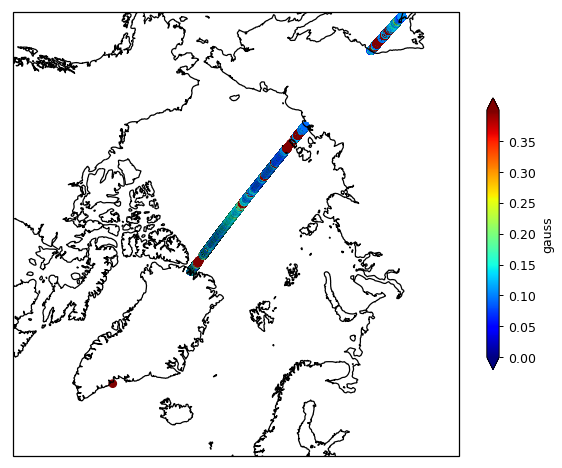

In [89]:
var= 'gauss' #choose which variable we want to plot

## we will want to set colorbar parameters based on the chosen variable
vmin=0
vmax=.4
ticks=np.arange(vmin,vmax,.05)


plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
plt.scatter(df07['lons'], df07['lats'],c=df07[var], cmap='jet', vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both')